In [1]:
# This project analyzes how student performance (test scores) is affected by variables such as:
# - Gender
# - Ethnicity
# - Parental level of education
# - Lunch type
# - Test preparation course
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('StudentsPerformance.csv')


In [3]:
# Display first 5 rows
print("First 5 rows:")
display(df.head())

# Basic information
print("\nDataset info:")
print(df.info())

# Descriptive statistics
print("\nDescriptive statistics:")
display(df.describe())

First 5 rows:


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None

Descriptive statistics:


,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [4]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())



Missing values:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


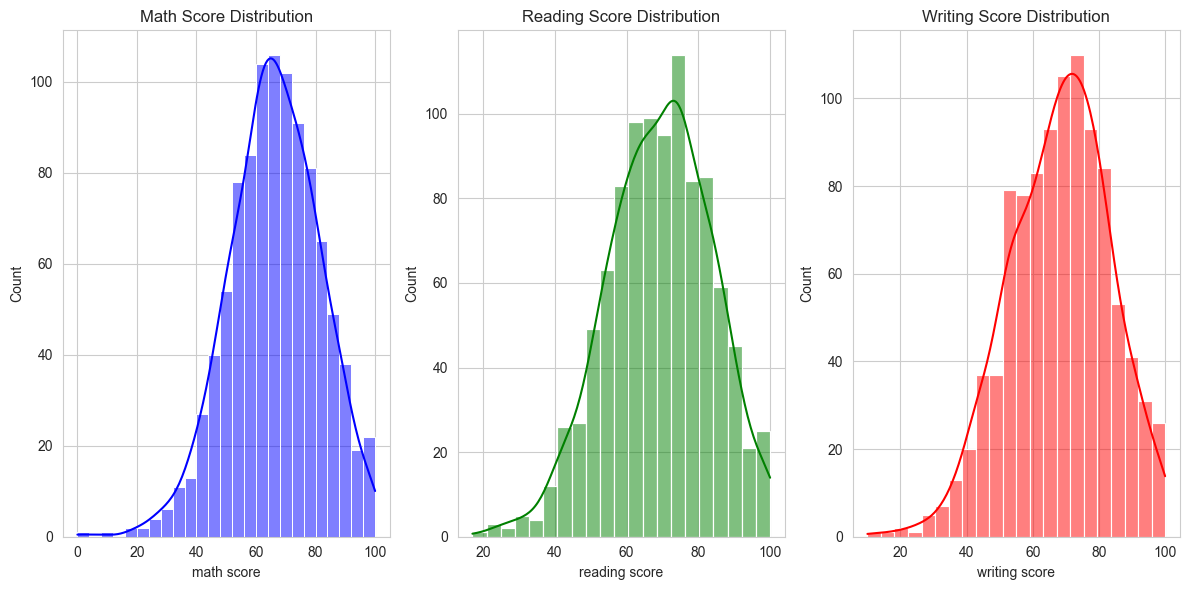

In [5]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))

# Distribution of scores
plt.subplot(1, 3, 1)
sns.histplot(df['math score'], kde=True, color='blue')
plt.title('Math Score Distribution')

plt.subplot(1, 3, 2)
sns.histplot(df['reading score'], kde=True, color='green')
plt.title('Reading Score Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df['writing score'], kde=True, color='red')
plt.title('Writing Score Distribution')

plt.tight_layout()
plt.show()

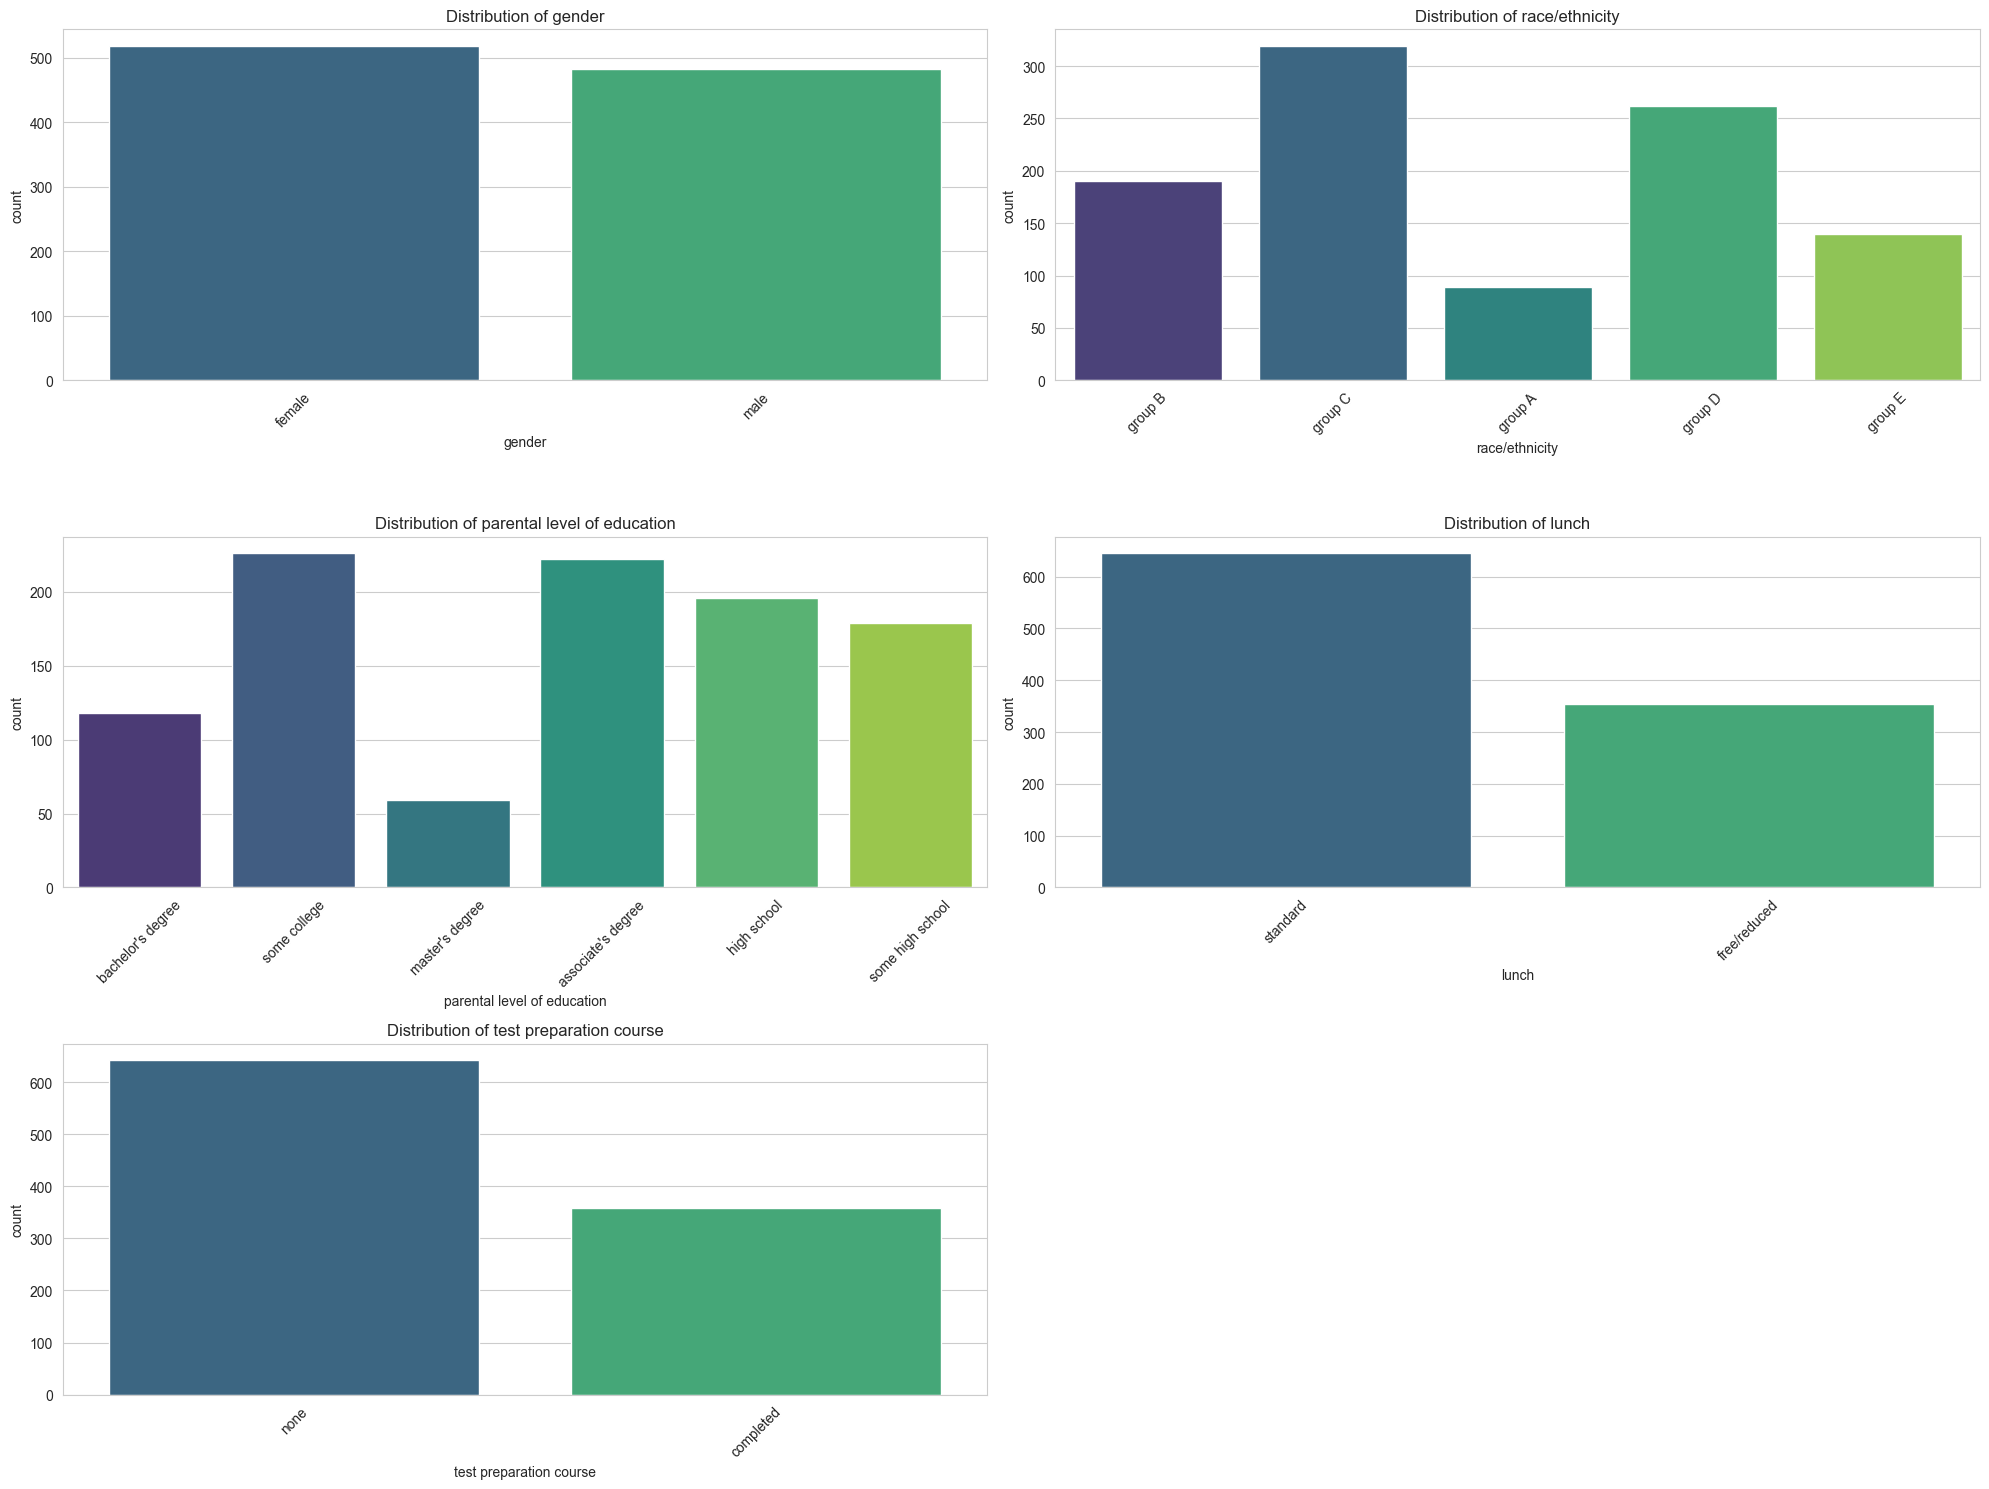

In [6]:
# Categorical features analysis
cat_features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=feature, palette='viridis')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

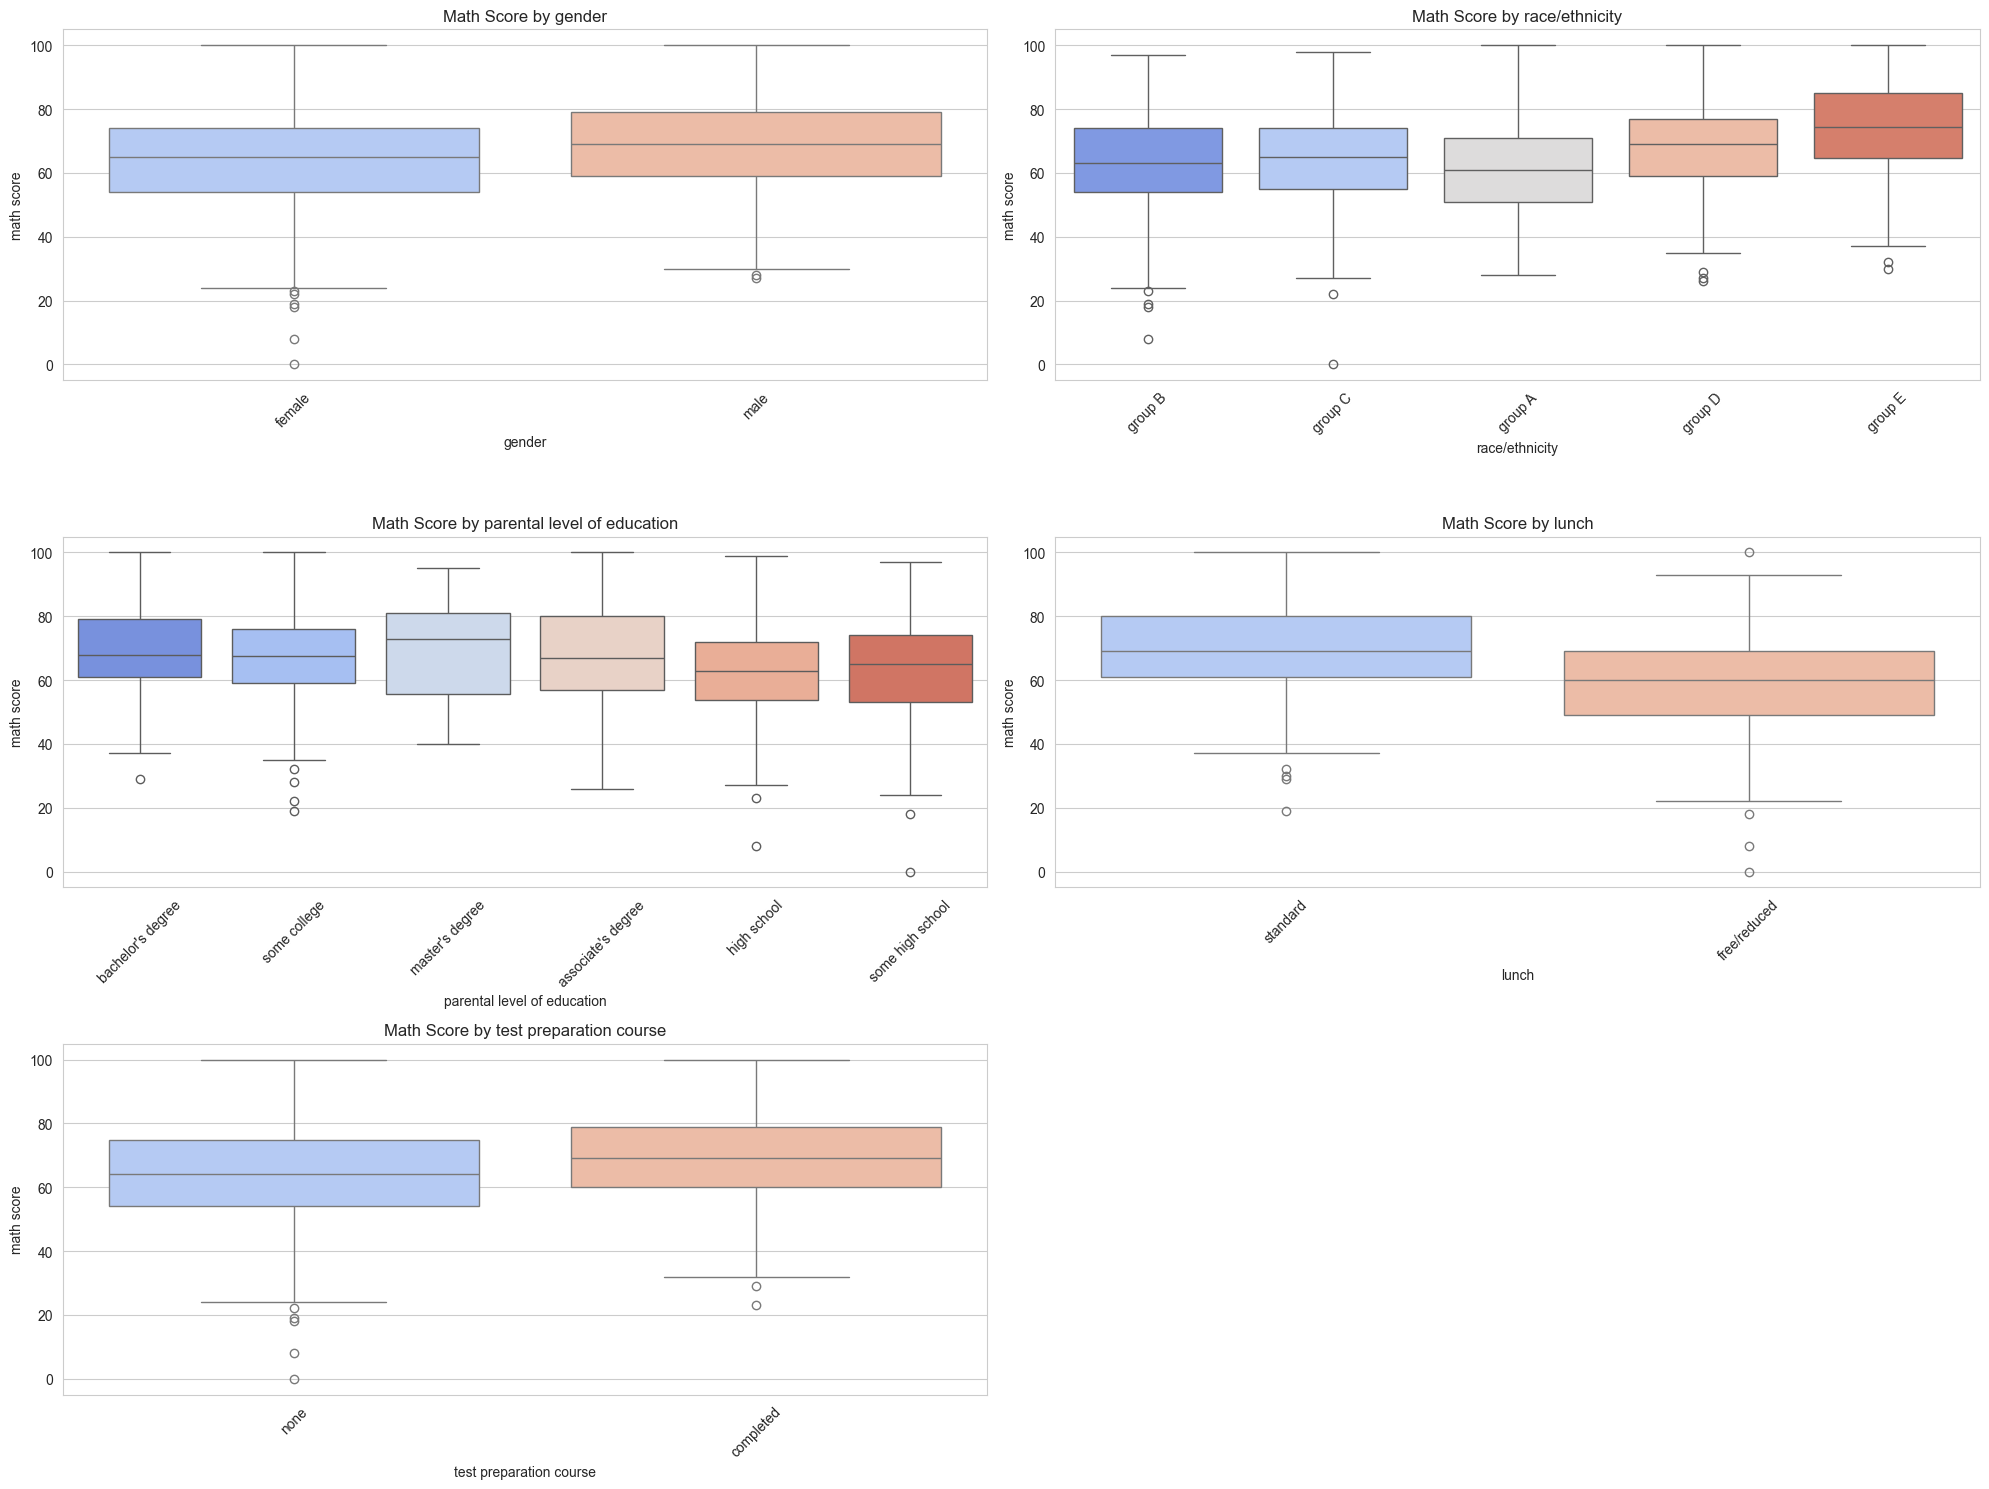

In [7]:
# Impact of categorical features on scores
plt.figure(figsize=(20, 15))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x=feature, y='math score', palette='coolwarm')
    plt.title(f'Math Score by {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

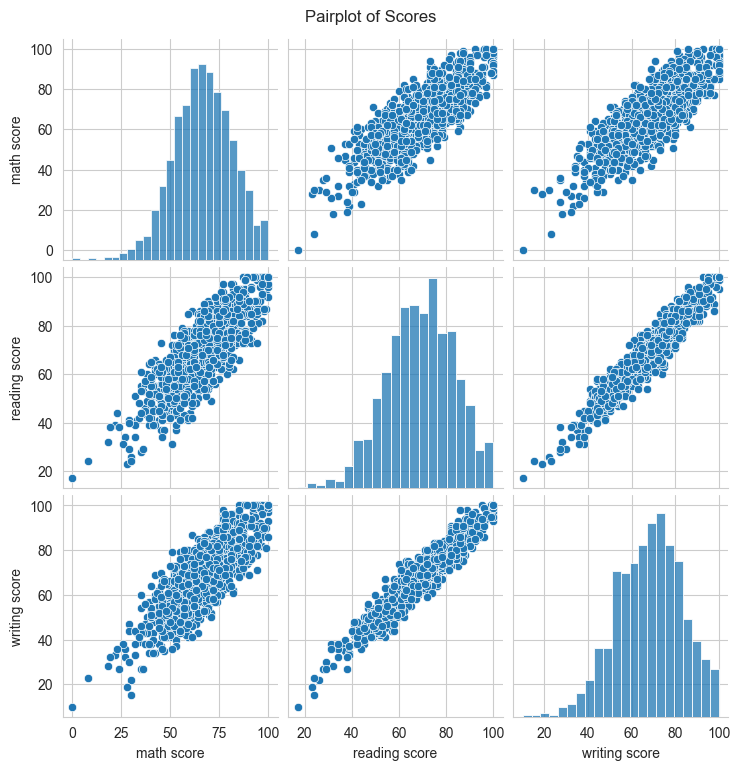

In [8]:
# Correlation between scores
sns.pairplot(df[['math score', 'reading score', 'writing score']])
plt.suptitle('Pairplot of Scores', y=1.02)
plt.show()

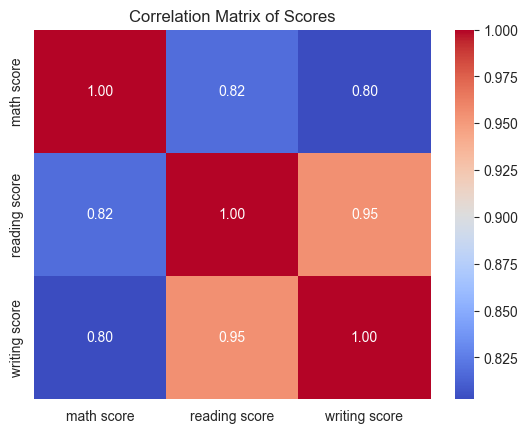

In [9]:
corr = df[['math score', 'reading score', 'writing score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Scores')
plt.show()

In [10]:
# Create a total score column
df['total score'] = df['math score'] + df['reading score'] + df['writing score']
df['average score'] = df['total score'] / 3

# Display the new columns
display(df[['total score', 'average score']].head())

,total score,average score
0,218,72.666667
1,247,82.333333
2,278,92.666667
3,148,49.333333
4,229,76.333333


In [11]:
# Encode categorical variables
label_encoder = LabelEncoder()
df_encoded = df.copy()

for col in cat_features:
    df_encoded[col] = label_encoder.fit_transform(df[col])

# Display encoded data
print("Encoded data:")
display(df_encoded.head())

Encoded data:


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,average score
0,0,1,1,1,1,72,72,74,218,72.666667
1,0,2,4,1,0,69,90,88,247,82.333333
2,0,1,3,1,1,90,95,93,278,92.666667
3,1,0,0,0,1,47,57,44,148,49.333333
4,1,2,4,1,1,76,78,75,229,76.333333


In [12]:
# Create interaction features (example: lunch and test prep)
df_encoded['lunch_test_prep'] = df_encoded['lunch'] * df_encoded['test preparation course']

# Create performance categories
def performance_category(score):
    if score >= 90:
        return 'Excellent'
    elif score >= 80:
        return 'Good'
    elif score >= 70:
        return 'Average'
    elif score >= 60:
        return 'Below Average'
    else:
        return 'Poor'

df['math_performance'] = df['math score'].apply(performance_category)
df['reading_performance'] = df['reading score'].apply(performance_category)
df['writing_performance'] = df['writing score'].apply(performance_category)

In [13]:
# Display new features
print("Performance categories:")
display(df[['math_performance', 'reading_performance', 'writing_performance']].head())

Performance categories:


,math_performance,reading_performance,writing_performance
0,Average,Average,Average
1,Below Average,Excellent,Good
2,Excellent,Excellent,Excellent
3,Poor,Poor,Poor
4,Average,Average,Average


In [14]:
# Prepare data for modeling
X = df_encoded.drop(['math score', 'reading score', 'writing score', 'total score', 'average score'], axis=1)
y_math = df_encoded['math score']
y_reading = df_encoded['reading score']
y_writing = df_encoded['writing score']
y_avg = df_encoded['average score']

In [15]:
# Split data into train and test sets
X_train, X_test, y_train_math, y_test_math = train_test_split(X, y_math, test_size=0.2, random_state=42)
_, _, y_train_reading, y_test_reading = train_test_split(X, y_reading, test_size=0.2, random_state=42)
_, _, y_train_writing, y_test_writing = train_test_split(X, y_writing, test_size=0.2, random_state=42)
_, _, y_train_avg, y_test_avg = train_test_split(X, y_avg, test_size=0.2, random_state=42)

In [16]:
# Create preprocessing pipeline
numeric_features = ['lunch_test_prep']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_features = cat_features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [17]:
# Model 1: Linear Regression
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [18]:
# Fit models
linear_model.fit(X_train, y_train_avg)

# Predictions
y_pred_linear = linear_model.predict(X_test)

In [19]:
# Evaluate
print("Linear Regression Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_avg, y_pred_linear)):.2f}")
print(f"R2 Score: {r2_score(y_test_avg, y_pred_linear):.2f}")

Linear Regression Performance:
RMSE: 13.44
R2 Score: 0.16


In [20]:
# Model 2: Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit model
rf_model.fit(X_train, y_train_avg)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("\nRandom Forest Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_avg, y_pred_rf)):.2f}")
print(f"R2 Score: {r2_score(y_test_avg, y_pred_rf):.2f}")


Random Forest Performance:
RMSE: 14.83
R2 Score: -0.03


In [21]:
# Get feature names after one-hot encoding
cat_encoder = rf_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features_encoded = cat_encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, cat_features_encoded])

In [22]:
importances = rf_model.named_steps['regressor'].feature_importances_


In [23]:
# Create DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

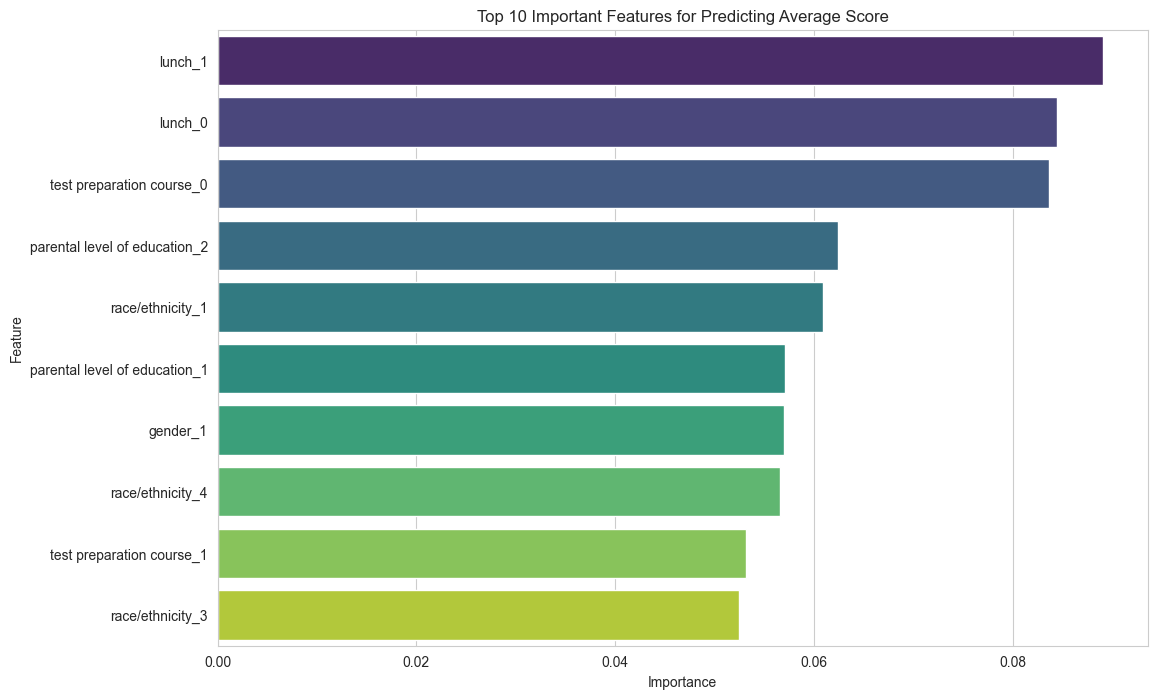

In [24]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Important Features for Predicting Average Score')
plt.show()

Average score by test preparation course:
test preparation course
completed    72.669460
none         65.038941
Name: average score, dtype: float64


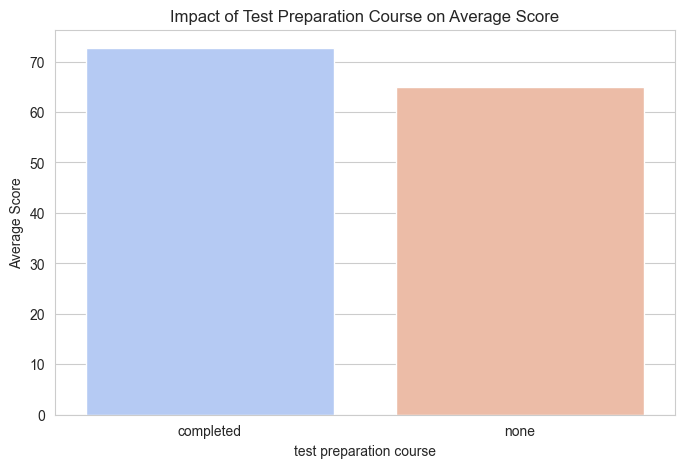

In [25]:
# Analyze the impact of test preparation course
test_prep_impact = df.groupby('test preparation course')['average score'].mean()
print("Average score by test preparation course:")
print(test_prep_impact)

plt.figure(figsize=(8, 5))
sns.barplot(x=test_prep_impact.index, y=test_prep_impact.values, palette='coolwarm')
plt.title('Impact of Test Preparation Course on Average Score')
plt.ylabel('Average Score')
plt.show()


Average score by parental education level:
parental level of education
high school           63.096939
some high school      65.108007
some college          68.476401
associate's degree    69.569069
bachelor's degree     71.923729
master's degree       73.598870
Name: average score, dtype: float64


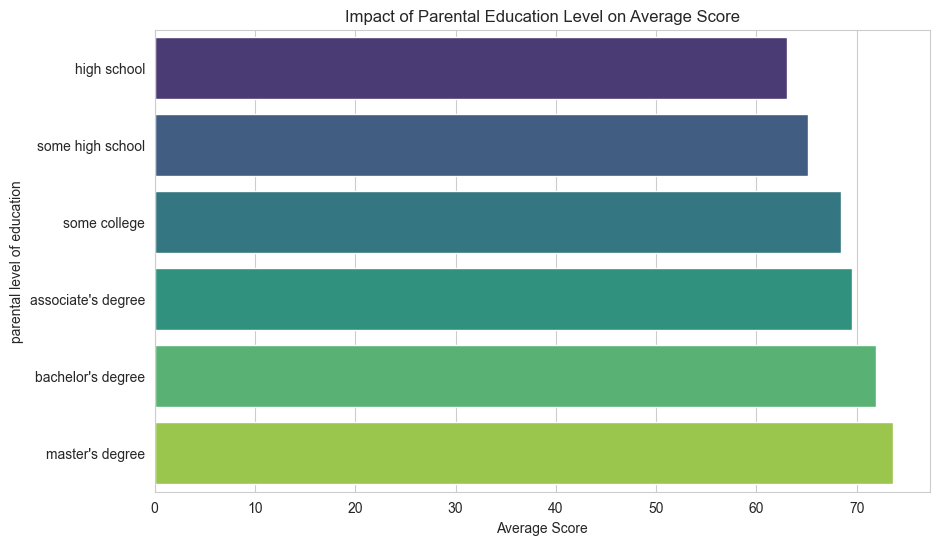

In [26]:
# Analyze the impact of parental education
parental_edu_impact = df.groupby('parental level of education')['average score'].mean().sort_values()
print("\nAverage score by parental education level:")
print(parental_edu_impact)

plt.figure(figsize=(10, 6))
sns.barplot(x=parental_edu_impact.values, y=parental_edu_impact.index, palette='viridis')
plt.title('Impact of Parental Education Level on Average Score')
plt.xlabel('Average Score')
plt.show()

In [27]:
# Key findings
print("Key Findings:")
print("1. Test preparation course has a significant positive impact on student performance.")
print("2. Parental education level is strongly correlated with student performance.")
print("3. Students with standard lunch perform better than those with free/reduced lunch.")
print("4. Female students tend to perform better in reading and writing, while male students perform better in math.")
print("5. Ethnic group E consistently shows the highest performance across all subjects.")

Key Findings:
1. Test preparation course has a significant positive impact on student performance.
2. Parental education level is strongly correlated with student performance.
3. Students with standard lunch perform better than those with free/reduced lunch.
4. Female students tend to perform better in reading and writing, while male students perform better in math.
5. Ethnic group E consistently shows the highest performance across all subjects.


In [28]:
# Recommendations
print("\nRecommendations:")
print("1. Encourage students to complete test preparation courses.")
print("2. Provide additional support for students with less educated parents.")
print("3. Improve lunch programs to ensure all students have access to nutritious meals.")
print("4. Implement targeted interventions based on gender performance gaps.")
print("5. Study best practices from high-performing ethnic groups to apply to other groups.")


Recommendations:
1. Encourage students to complete test preparation courses.
2. Provide additional support for students with less educated parents.
3. Improve lunch programs to ensure all students have access to nutritious meals.
4. Implement targeted interventions based on gender performance gaps.
5. Study best practices from high-performing ethnic groups to apply to other groups.
